In [4]:
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os

from PIL import Image

import pandas as pd
from xml.dom import minidom
import csv

In [5]:
def extract_xml_contents(annot_directory, image_dir):
        
        file = minidom.parse(annot_directory)

        # Get the height and width for our image
        height, width = cv2.imread(image_dir).shape[:2]

        # Get the bounding box co-ordinates 
        xmin = file.getElementsByTagName('xmin')
        x1 = float(xmin[0].firstChild.data)

        ymin = file.getElementsByTagName('ymin')
        y1 = float(ymin[0].firstChild.data)

        xmax = file.getElementsByTagName('xmax')
        x2 = float(xmax[0].firstChild.data)

        ymax = file.getElementsByTagName('ymax')
        y2 = float(ymax[0].firstChild.data)

        class_name = file.getElementsByTagName('name')

        if class_name[0].firstChild.data == "cat":
          class_num = 0
        else:
          class_num = 1

        files = file.getElementsByTagName('filename')
        filename = files[0].firstChild.data

        # Return the extracted attributes
        return filename,  width, height, class_num, x1,y1,x2,y2

In [6]:
num_to_labels= {0:'cat',1:'dog'}


In [7]:
# Function to convert XML files to CSV
def xml_to_csv():

  # List containing all our attributes regarding each image
  xml_list = []

  # We loop our each class and its labels one by one to preprocess and augment 
  image_dir = 'dataset/images'
  annot_dir = 'dataset/annot'

  # Get each file in the image and annotation directory
  mat_files = os.listdir(annot_dir)
  img_files = os.listdir(image_dir)

  # Loop over each of the image and its label
  for mat, image_file in zip(mat_files, img_files):
      
      # Full mat path
      mat_path = os.path.join(annot_dir, mat)

      # Full path Image
      img_path = os.path.join(image_dir, image_file)

      # Get Attributes for each image 
      value = extract_xml_contents(mat_path, img_path)

      # Append the attributes to the mat_list
      xml_list.append(value)

  # Columns for Pandas DataFrame
  column_name = ['filename', 'width', 'height', 'class_num', 'xmin', 'ymin', 
                 'xmax', 'ymax']

  # Create the DataFrame from mat_list
  xml_df = pd.DataFrame(xml_list, columns=column_name)

  # Return the dataframe
  return xml_df

# The Classes we will use for our training
classes_list = sorted(['cat',  'dog'])

# Run the function to convert all the xml files to a Pandas DataFrame
labels_df = xml_to_csv()

# Saving the Pandas DataFrame as CSV File
labels_df.to_csv(('dataset.csv'), index=None)

In [8]:
def preprocess_dataset():
  # Lists that will contain the whole dataset
  labels = []
  boxes = []
  img_list = []

  h = 256
  w = 256
  image_dir = 'dataset/images'

  with open('dataset.csv') as csvfile:
      rows = csv.reader(csvfile)
      columns = next(iter(rows))
      for row in rows:
        labels.append(int(row[3]))
        #Scaling Coordinates to the range of [0,1] by dividing the coordinate with image size, 256 here.
        arr = [float(row[4])/256,  
               float(row[5])/256,
               float(row[6])/256,
               float(row[7])/256]
        boxes.append(arr)
        img_path = row[0]
        # Read the image
        img  = cv2.imread(os.path.join(image_dir,img_path))

        # Resize all images to a fix size
        image = cv2.resize(img, (256, 256))

        # # Convert the image from BGR to RGB as NasNetMobile was trained on RGB images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize the image by dividing it by 255.0 
        image = image.astype("float") / 255.0

        # Append it to the list of images
        img_list.append(image)

  return labels, boxes, img_list

In [9]:
# All images will resized to 300, 300 
image_size = 256

# Get Augmented images and bounding boxes
labels, boxes, img_list = preprocess_dataset()

# Now we need to shuffle the data, so zip all lists and shuffle
combined_list = list(zip(img_list, boxes, labels))
random.shuffle(combined_list)

# Extract back the contents of each list
img_list, boxes, labels = zip(*combined_list)

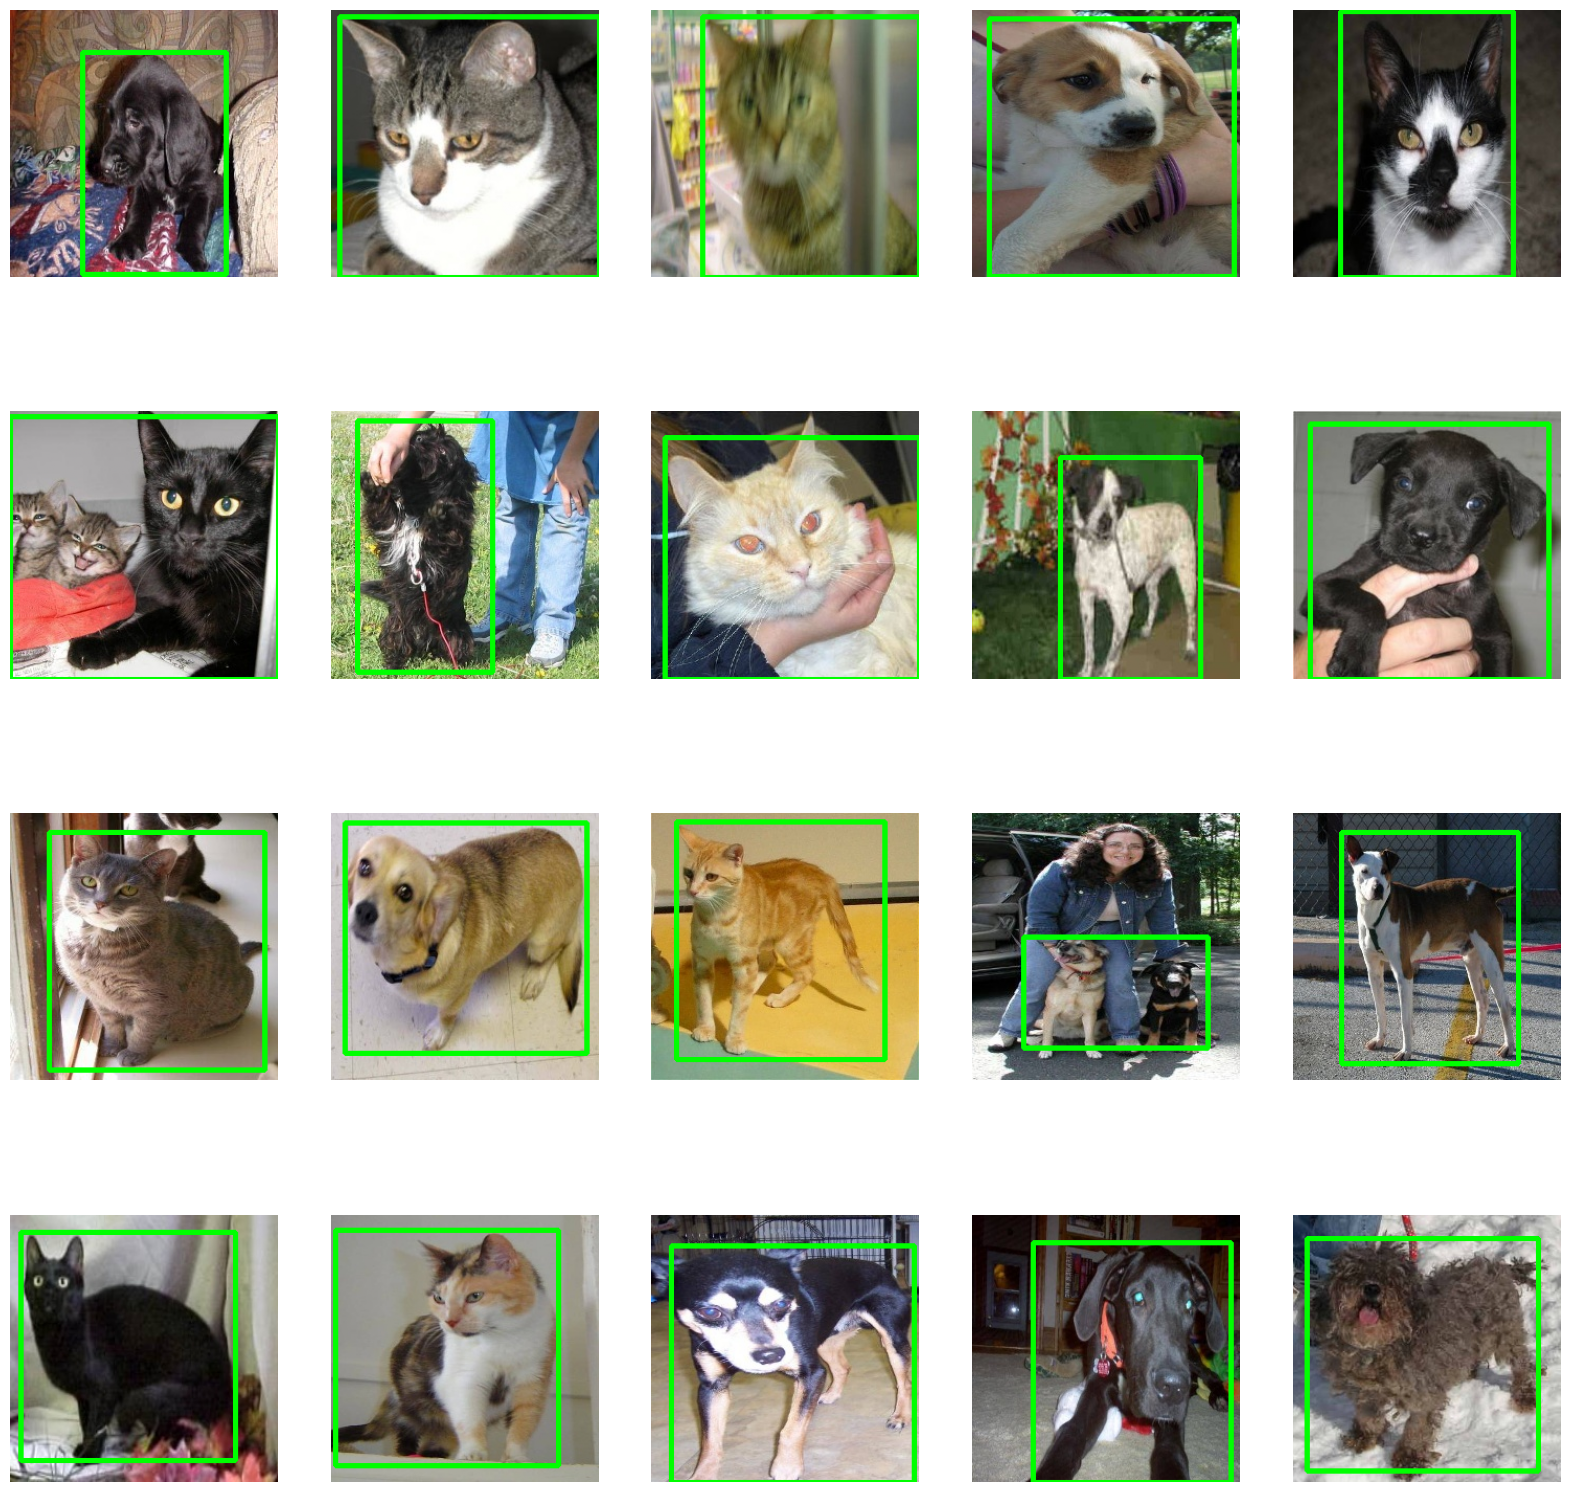

In [10]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20));

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(img_list)), 20)

for itr, i in enumerate(random_range, 1):

    # Bounding box of each image
    a1, b1, a2, b2 = boxes[i];
    img_size = 256

    # Rescaling the boundig box values to match the image size
    x1 = a1 * img_size
    x2 = a2 * img_size
    y1 = b1 * img_size
    y2 = b2 * img_size

    # The image to visualize
    image = img_list[i]

    # Draw bounding boxes on the image
    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    # Clip the values to 0-1 and draw the sample of images
    img = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, itr);
    plt.imshow(img);
    plt.axis('off');

In [11]:
# Split the data of images, labels and their annotations
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(labels), np.array(boxes), test_size = 0.2, 
                random_state = 43)

print('Training Images Count: {}, Validation Images Count: {}'.format(
    len(train_images), len(val_images) ))

Training Images Count: 960, Validation Images Count: 240


In [12]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle
import random
import time

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [14]:
class Dataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = torch.permute(torch.from_numpy(train_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()

    def __len__(self):
        return len(self.labels)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])

# Inheriting from Dataset class

class ValDataset(Dataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = torch.permute(torch.from_numpy(val_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()

In [15]:
dataset = Dataset(train_images, train_labels, train_boxes)
valdataset = ValDataset(val_images, val_labels, val_boxes)

In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        # CNNs for rgb images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)


        # Connecting CNN outputs with Fully Connected layers for classification
        self.class_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.class_fc2 = nn.Linear(in_features=240, out_features=120)
        self.class_out = nn.Linear(in_features=120, out_features=2)

        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.box_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.box_fc2 = nn.Linear(in_features=240, out_features=120)
        self.box_out = nn.Linear(in_features=120, out_features=4)


    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)

        t = torch.flatten(t,start_dim=1)
        

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = F.softmax(self.class_out(class_t),dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = F.sigmoid(box_t)

        return [class_t,box_t]

In [17]:
model = Network()
model = model.to(device)
model

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(48, 192, kernel_size=(5, 5), stride=(1, 1))
  (class_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (class_fc2): Linear(in_features=240, out_features=120, bias=True)
  (class_out): Linear(in_features=120, out_features=2, bias=True)
  (box_fc1): Linear(in_features=1728, out_features=240, bias=True)
  (box_fc2): Linear(in_features=240, out_features=120, bias=True)
  (box_out): Linear(in_features=120, out_features=4, bias=True)
)

In [18]:
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [19]:
dataloader = torch.utils.data.DataLoader(
       dataset, batch_size=32, shuffle=True)
valdataloader = torch.utils.data.DataLoader(
       valdataset, batch_size=32, shuffle=True)

In [94]:
def train(model):
    # Defining the optimizer
    optimizer = optim.SGD(model.parameters(),lr = 0.1)
    num_of_epochs = 300
    epochs = []
    losses = []
    # Creating a directory for storing models
    os.mkdir('models')
    for epoch in range(num_of_epochs):
        tot_loss = 0
        tot_correct = 0
        train_start = time.time()
        model.train()
        for batch, (x, y, z) in enumerate(dataloader):
        	# Converting data from cpu to GPU if available to improve speed
            x,y,z = x.to(device),y.to(device),z.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            [y_pred,z_pred]= model(x)
            # Compute loss (here CrossEntropyLoss)
            class_loss = F.cross_entropy(y_pred, y)
            box_loss = F.mse_loss(z_pred, z)
            (box_loss + class_loss).backward()
            # class_loss.backward()
            optimizer.step()
            print("Train batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')

        model.eval()
        for batch, (x, y,z) in enumerate(valdataloader):
        	# Converting data from cpu to GPU if available to improve speed	
            x,y,z = x.to(device),y.to(device),z.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                [y_pred,z_pred]= model(x)
                
                # Compute loss (here CrossEntropyLoss)
                class_loss = F.cross_entropy(y_pred, y)
                box_loss = F.mse_loss(z_pred, z)
                # Compute loss (here CrossEntropyLoss)

            tot_loss += (class_loss.item() + box_loss.item())
            tot_correct += get_num_correct(y_pred, y)
            print("Test batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch", epoch, "Accuracy", (tot_correct)/2.4, "loss:",
              tot_loss, " time: ", (time.time()-train_start)/60, " mins")
        torch.save(model.state_dict(), "model_ep"+str(epoch+1)+".pth")

In [95]:
train(model)


Epoch 0 Accuracy 63.333333333333336 loss: 5.507609641179442  time:  0.048857518037160236  mins
Epoch 1 Accuracy 63.333333333333336 loss: 5.574989444576204  time:  0.04492715994517008  mins
Epoch 2 Accuracy 63.333333333333336 loss: 5.44599321205169  time:  0.045198206106821695  mins
Epoch 3 Accuracy 63.333333333333336 loss: 5.429582809098065  time:  0.04552029371261597  mins
Epoch 4 Accuracy 62.91666666666667 loss: 5.434562551788986  time:  0.04520023266474406  mins
Epoch 5 Accuracy 62.5 loss: 5.558439307846129  time:  0.04470705986022949  mins
Epoch 6 Accuracy 62.91666666666667 loss: 5.556335803121328  time:  0.04492726723353068  mins
Epoch 7 Accuracy 62.91666666666667 loss: 5.5380877940915525  time:  0.045322946707407635  mins
Epoch 8 Accuracy 62.91666666666667 loss: 5.483668673783541  time:  0.04513185818990072  mins
Epoch 9 Accuracy 62.91666666666667 loss: 5.52562237996608  time:  0.045200876394907635  mins
Epoch 10 Accuracy 62.91666666666667 loss: 5.5230755363591015  time:  0.04539

Epoch 92 Accuracy 62.91666666666667 loss: 5.552746404893696  time:  0.046218244234720866  mins
Epoch 93 Accuracy 62.91666666666667 loss: 5.52453067433089  time:  0.046040078004201256  mins
Epoch 94 Accuracy 62.91666666666667 loss: 5.535454222932458  time:  0.04651965697606405  mins
Epoch 95 Accuracy 62.91666666666667 loss: 5.646770283579826  time:  0.04579582214355469  mins
Epoch 96 Accuracy 62.91666666666667 loss: 5.500817129388452  time:  0.0459410826365153  mins
Epoch 97 Accuracy 62.91666666666667 loss: 5.630874739028513  time:  0.04618226687113444  mins
Epoch 98 Accuracy 62.91666666666667 loss: 5.613728879019618  time:  0.04576943318049113  mins
Epoch 99 Accuracy 62.91666666666667 loss: 5.60011356510222  time:  0.04594407478968302  mins
Epoch 100 Accuracy 62.91666666666667 loss: 5.567777746357024  time:  0.0456670085589091  mins
Epoch 101 Accuracy 62.91666666666667 loss: 5.603073472157121  time:  0.04602061907450358  mins
Epoch 102 Accuracy 62.91666666666667 loss: 5.611254638060927

Epoch 178 Accuracy 63.333333333333336 loss: 5.648505094461143  time:  0.046523590882619224  mins
Epoch 179 Accuracy 63.333333333333336 loss: 5.516950501129031  time:  0.046225225925445555  mins
Epoch 180 Accuracy 63.333333333333336 loss: 5.634954404085875  time:  0.04620669285456339  mins
Epoch 181 Accuracy 63.333333333333336 loss: 5.580577318556607  time:  0.04649087190628052  mins
Epoch 182 Accuracy 63.333333333333336 loss: 5.712341716513038  time:  0.04625800053278605  mins
Epoch 183 Accuracy 63.333333333333336 loss: 5.539238871075213  time:  0.046528947353363034  mins
Epoch 184 Accuracy 63.333333333333336 loss: 5.543599294498563  time:  0.046686617533365886  mins
Epoch 185 Accuracy 63.333333333333336 loss: 5.670258745551109  time:  0.04621717532475789  mins
Epoch 186 Accuracy 63.333333333333336 loss: 5.675948869436979  time:  0.04633067846298218  mins
Epoch 187 Accuracy 63.333333333333336 loss: 5.605446018278599  time:  0.0459807554880778  mins
Epoch 188 Accuracy 63.333333333333336

Epoch 267 Accuracy 63.75 loss: 5.617266835644841  time:  0.04611530701319377  mins
Epoch 268 Accuracy 63.75 loss: 5.541989728808403  time:  0.04657195409138997  mins
Epoch 269 Accuracy 63.75 loss: 5.667253420688212  time:  0.046674315134684244  mins
Epoch 270 Accuracy 63.75 loss: 5.63609460555017  time:  0.04697965780893962  mins
Epoch 271 Accuracy 63.75 loss: 5.617146780714393  time:  0.04647481044133504  mins
Epoch 272 Accuracy 63.75 loss: 5.540382903069258  time:  0.04640804529190064  mins
Epoch 273 Accuracy 63.75 loss: 5.542615828104317  time:  0.04601156711578369  mins
Epoch 274 Accuracy 63.75 loss: 5.58550828974694  time:  0.04648023049036662  mins
Epoch 275 Accuracy 63.75 loss: 5.570010454393923  time:  0.04710288047790527  mins
Epoch 276 Accuracy 63.75 loss: 5.6026646457612514  time:  0.046541881561279294  mins
Epoch 277 Accuracy 63.75 loss: 5.519111760891974  time:  0.046099507808685304  mins
Epoch 278 Accuracy 63.75 loss: 5.612290332093835  time:  0.046644035975138345  mins
E

In [85]:
def preprocess(img, image_size = 256):
    
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    # Expand dimensions as predict expect image in batches
    image = np.expand_dims(image, axis=0) 
    return image

In [86]:
def postprocess(image, results):

    # Split the results into class probabilities and box coordinates
    [class_probs, bounding_box] = results

    # First let's get the class label

    # The index of class with the highest confidence is our target class
#     class_index = torch.argmax(class_probs)
#     class_index = int(class_index)
    class_index = int(torch.argmax(class_probs))
  
    # Use this index to get the class name.
    class_label = num_to_labels[class_index]

    # Now you can extract the bounding box too.

    # Get the height and width of the actual image
    h, w = 256,256

    # Extract the Coordinates
    x1, y1, x2, y2 = bounding_box[0]

    # # Convert the coordinates from relative (i.e. 0-1) to actual values
    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    # return the lable and coordinates
    return class_label, (x1,y1,x2,y2),torch.max(class_probs)*100

In [96]:
# We will use this function to make prediction on images.
def predict(image,  scale = 0.5):
  model = Network()
  model = model.to(device)
  model.load_state_dict(torch.load("models/model_ep299.pth"))
  model.eval()
  
  # Reading Image
  img  = cv2.imread(image)
  
  # # Before we can make a prediction we need to preprocess the image.
  processed_image = preprocess(img)

  result = model(torch.permute(torch.from_numpy(processed_image).float(),(0,3,1,2)).to(device))

  # After postprocessing, we can easily use our results
  label, (x1, y1, x2, y2), confidence = postprocess(image, result)

  # Now annotate the image
  cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText(
      img, 
      '{}, CONFIDENCE: {}'.format(label, confidence), 
      (30, int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (200, 55, 100),
      2
      )

  # Show the Image with matplotlib
  plt.figure(figsize=(10,10))
  plt.imshow(img[:,:,::-1])

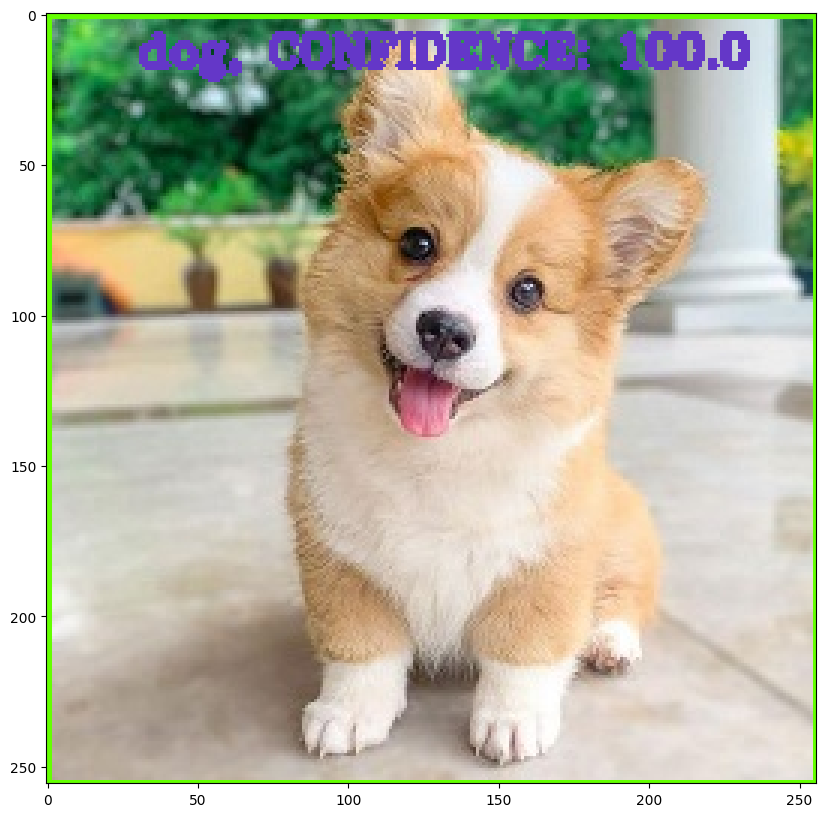

In [105]:
image = 'corgi.jpg'
predict(image)

In [106]:
model = Network()
model = model.to(device)
model.load_state_dict(torch.load('models/model_ep299.pth'))
model.eval()
random_input = torch.randn(1, 3, 256, 256, dtype=torch.float32).to(device)
# you can add however many inputs your model or task requires
 
input_names = ["input"]
output_names = ["cls","loc"]
 
torch.onnx.export(model, random_input, 'localization_model.onnx', verbose=False, 
                  input_names=input_names, output_names=output_names, 
                  opset_version=11)
print("DONE")

DONE
